<a href="https://colab.research.google.com/github/ILYSHI/Neuronets/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B8_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%82%D1%82%D0%BE%D0%BA%D0%B0_%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [ ]:
# Подключаю google-disk, где хранится kaggle.json файл с личным профилем на kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Перенос файла-идентификатора из облака в рабочую директорию сеанса
import os
import shutil
!rm -rf root/.kaggle
kaggle_root = '/root/.kaggle/'
source_dir = '/content/drive/MyDrive/'
os.makedirs(kaggle_root)
shutil.copy(os.path.join(source_dir, 'kaggle.json'),os.path.join(kaggle_root,'kaggle.json'))

'/root/.kaggle/kaggle.json'

In [ ]:
# Скачиваем набор данных
!kaggle competitions download -c advanced-dls-fall-2020


  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 31.1MB/s]
  0% 0.00/648k [00:00<?, ?B/s]
100% 648k/648k [00:00<00:00, 41.1MB/s]
  0% 0.00/14.4k [00:00<?, ?B/s]
100% 14.4k/14.4k [00:00<00:00, 14.5MB/s]


In [ ]:
data = pd.read_csv('./train.csv')

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
# Первый взгляд на данные
print(data.shape)
print('='*60)
print(data.describe())
print('='*60)
print(data.info())
print('='*60)
print(data.head(5))
print('='*60)
#Случайные строчки
print(data.sample(5))

(5282, 20)
       ClientPeriod  MonthlySpending  IsSeniorCitizen        Churn
count   5282.000000      5282.000000      5282.000000  5282.000000
mean      32.397009        64.924754         0.159409     0.262022
std       24.550326        30.176464         0.366092     0.439776
min        0.000000        18.250000         0.000000     0.000000
25%        9.000000        35.462500         0.000000     0.000000
50%       29.000000        70.400000         0.000000     0.000000
75%       55.000000        90.050000         0.000000     1.000000
max       72.000000       118.750000         1.000000     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3  

In [ ]:
# Простая проверка на NA
data.isna().mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [ ]:
# В колонке TotalSpent обнаружены пустые значения в виде пробелов, как Na не определяются.
# Найдем их, присвоив им значение NA
empty_values = []
for i,k in enumerate(data.TotalSpent):
  try:
    float(k)
  except:
    empty_values.append(i)
print(empty_values)

data.TotalSpent.iloc[empty_values] = None
data.TotalSpent = data.TotalSpent.astype(float)
data.TotalSpent = data.TotalSpent.fillna(data.TotalSpent.median())

[1048, 1707, 2543, 3078, 3697, 4002, 4326, 4551, 4598]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


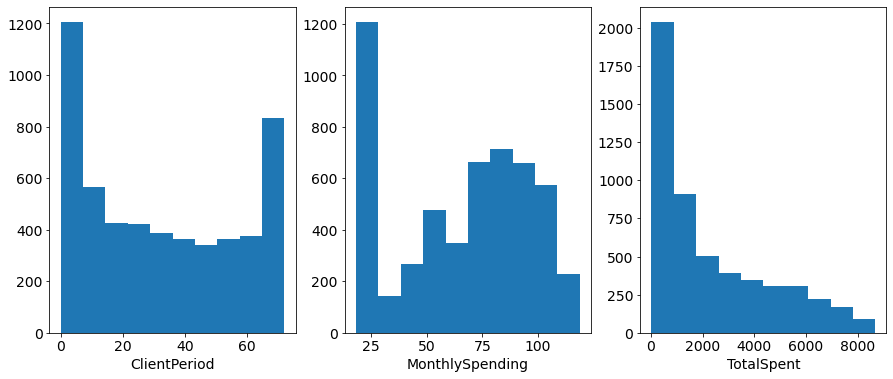

In [ ]:
# Числовые признаки
plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 14})
for i,col in enumerate(num_cols):
  plt.subplot(1,len(num_cols),(i+1))
  plt.hist(data[col])
  plt.xlabel(col)

In [ ]:
cat_cols

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

In [ ]:
cats_test = ['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV']

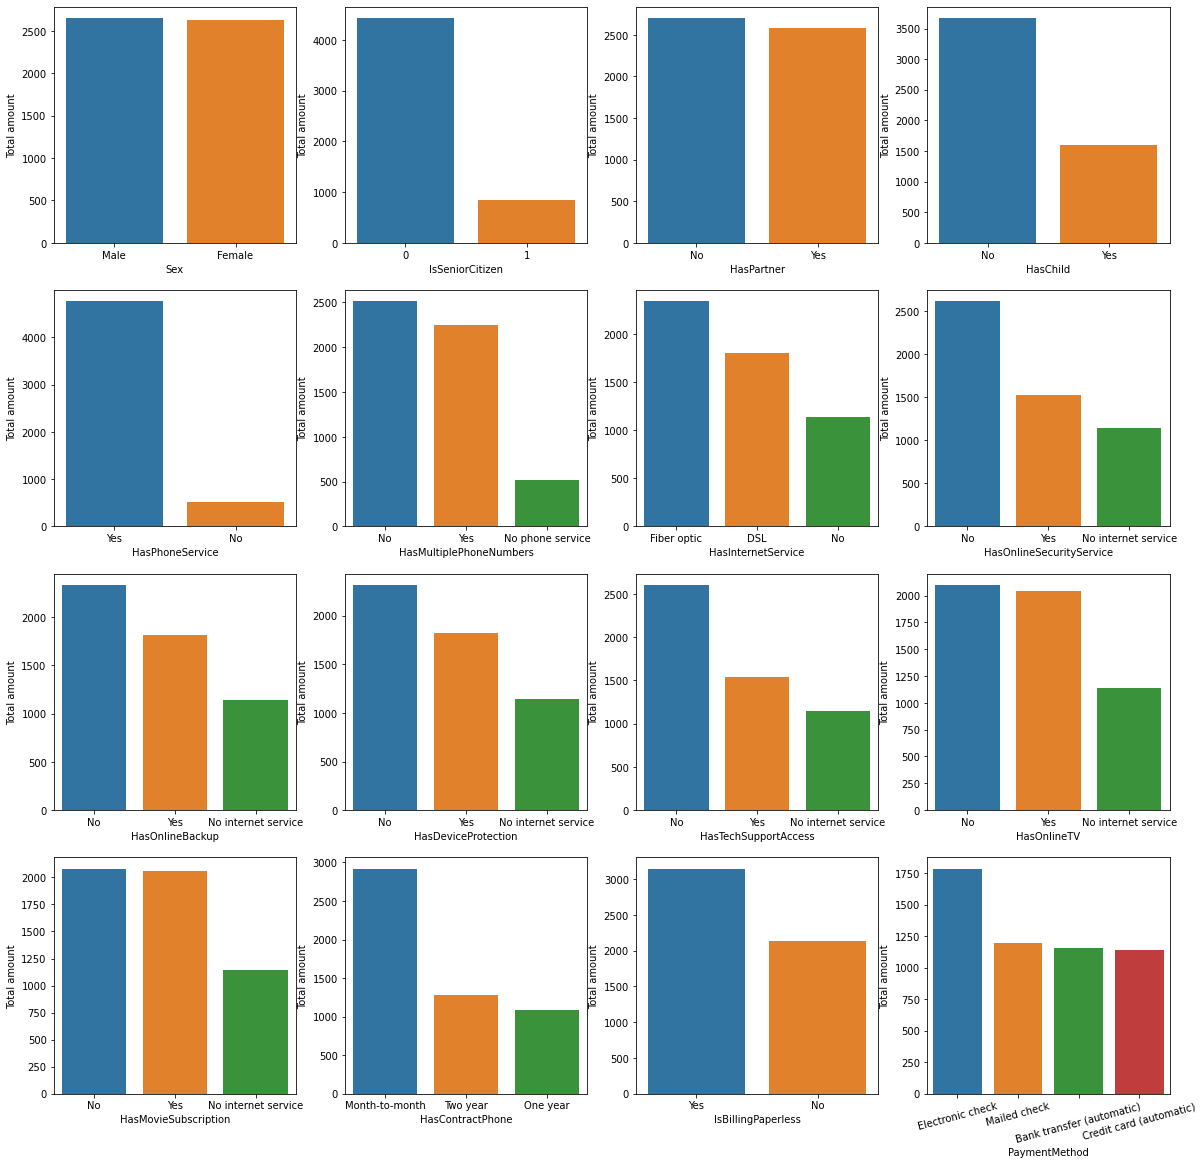

In [ ]:
# Распределение по категориальным признакам
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,20))
for i, cat in enumerate(cat_cols):
    Bar = data[cat].value_counts().to_frame().reset_index()
    plt.subplot(4,4,(i+1))
    sns.barplot(data=Bar, x='index', y = cat_cols[i])
    plt.xlabel(cat_cols[i])
    plt.ylabel('Total amount')
    if i==15:        
        plt.xticks(rotation=15)


Text(0.5, 0, 'Is gone')

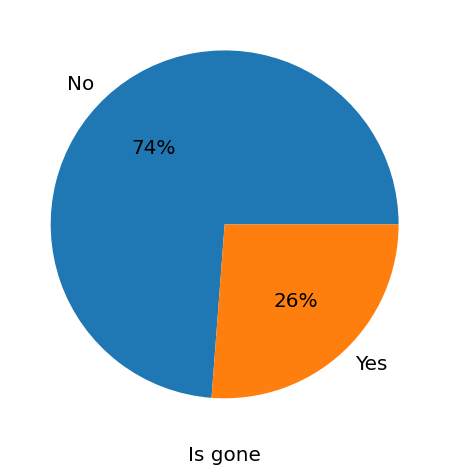

In [ ]:
plt.rcParams.update({'font.size': 20})
target_class = data.Churn.value_counts()
target_class.index = ['No','Yes']
plt.figure(figsize=(8,8))
target_class.plot.pie(autopct='%1.0f%%')

plt.ylabel('')
plt.xlabel('Is gone')

# Классы сильно несбалансированны.
# У этого есть неприятные последствия: если модель будет в 100% случаев утверждать, 
# что клиент не уйдет, она будет права на 74%. Это мнимая и бесполезная точность.

In [ ]:
# Преобразуем числовой формат в категориальный
data.IsSeniorCitizen = data.IsSeniorCitizen.astype('category')

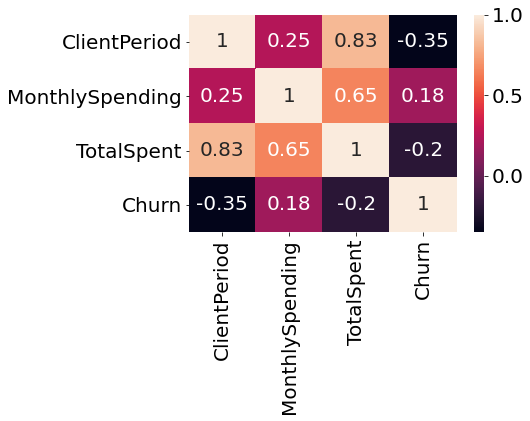

In [ ]:
# Изучим корреляцию по столбцам:

correlation = data.corr()

sns.heatmap(correlation, annot=True)

In [ ]:
# Форматирование данных в формат Х,y

X = data.drop(target_col,axis=1)
y = data[target_col]

In [ ]:
X.shape, y.shape

((5282, 19), (5282,))

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2291.390461,0.262022
std,24.550326,30.176464,2267.079956,0.439776
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.462500,401.587500,0.000000
50%,29.000000,70.400000,1413.650000,0.000000
75%,55.000000,90.050000,3795.212500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [ ]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegressionCV())])

# (Cs=10, fit_intercept=True, cv=None, 
#  dual=False, penalty='l2', scoring=None, 
#  solver='lbfgs', tol=0.0001, max_iter=100, 
#  class_weight=None, n_jobs=None, verbose=0, 
#  refit=True, intercept_scaling=1.0,
#  multi_class='auto', random_state=None, l1_ratios=None)


parameters = {'classifier__Cs':range(0,25,5),
              'classifier__penalty': ['l2','elasticnet'],
              'classifier__solver':['lbfgs', 'liblinear','saga']
              }
grid_clf = GridSearchCV(estimator=clf, param_grid=parameters, scoring='accuracy',cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)
# print(X_train.shape,y_train.shape, X_test.shape, y_test)
# clf.fit(X_train, y_train)

# print("model score: %.3f" % clf.score(X_test, y_test))

grid_clf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: cannot reshape array of size 0 into shape (1,5,0,newaxis)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: cannot reshape array of size 0 into shape (1,5,0,newaxis)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: cannot reshape array of size 0 into shape (1,5,0,newaxis)

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFa

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['ClientPeriod',
                                                                          '

In [ ]:
# Лучшие параметры
grid_clf.best_params_

{'classifier__Cs': 15,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Cs = 21;                                     Result = 0.84330

Cs = 15, penalty = 'l2', solver ='liblinear' Result = 0.84330


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

## Catboost

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

cat_clf = CatBoostClassifier(cat_features=cat_cols)
'''
              (iterations=None, learning_rate=None, 
             depth=None, l2_leaf_reg=None,
             model_size_reg=None, rsm=None, 
             loss_function=None, border_count=None, 
             feature_border_type=None, 
             per_float_feature_quantization=None, 
             input_borders=None, output_borders=None, 
             fold_permutation_block=None, od_pval=None, 
             od_wait=None, od_type=None, nan_mode=None, 
             counter_calc_method=None, 
             leaf_estimation_iterations=None, 
             leaf_estimation_method=None, thread_count=None,
             random_seed=None, use_best_model=None, 
             best_model_min_trees=None, verbose=None,
             silent=None, logging_level=None,
             metric_period=None, ctr_leaf_count_limit=None, 
             store_all_simple_ctr=None, max_ctr_complexity=None,
             has_time=None, allow_const_label=None, 
             target_border=None, classes_count=None, 
             class_weights=None, auto_class_weights=None,
             class_names=None, one_hot_max_size=None, 
             random_strength=None, name=None, ignored_features=None, 
             train_dir=None, custom_loss=None, custom_metric=None, 
             eval_metric=None, bagging_temperature=None, save_snapshot=None,
             snapshot_file=None, snapshot_interval=None, fold_len_multiplier=None, 
             used_ram_limit=None, gpu_ram_part=None, pinned_memory_size=None, allow_writing_files=None, 
             final_ctr_computation_mode=None, approx_on_full_history=None, boosting_type=None,
             simple_ctr=None, combinations_ctr=None, per_feature_ctr=None, ctr_description=None, 
             ctr_target_border_count=None, task_type=None, device_config=None, devices=None, 
             bootstrap_type=None, subsample=None, mvs_reg=None, sampling_unit=None, 
             sampling_frequency=None, dev_score_calc_obj_block_size=None, dev_efb_max_buckets=None, 
             sparse_features_conflict_fraction=None, max_depth=None, n_estimators=None, num_boost_round=None,
             num_trees=None, colsample_bylevel=None, random_state=None, reg_lambda=None, objective=None,
             eta=None, max_bin=None, scale_pos_weight=None, gpu_cat_features_storage=None, data_partition=None, 
             metadata=None, early_stopping_rounds=None, cat_features=None, grow_policy=None, min_data_in_leaf=None,
             min_child_samples=None, max_leaves=None, num_leaves=None, score_function=None, 
             leaf_estimation_backtracking=None, ctr_history_unit=None, monotone_constraints=None,
             feature_weights=None, penalties_coefficient=None, first_feature_use_penalties=None, 
             per_object_feature_penalties=None, model_shrink_rate=None, model_shrink_mode=None,
             langevin=None, diffusion_temperature=None, posterior_sampling=None, boost_from_average=None, 
             text_features=None, tokenizers=None, dictionaries=None, feature_calcers=None, 
             text_processing=None, embedding_features=None)
'''


parameters = {'learning_rate':[0.01],
              'n_estimators':[200],
              'min_child_samples' : [2],
              'score_function' : ['SolarL2','NewtonL2','SatL2','L2']

              }
cat_grid_clf = GridSearchCV(estimator=cat_clf, param_grid=parameters, scoring='accuracy',cv=3)

cat_grid_clf.fit(X_train, y_train)

print("roc-auc: %.3f" % roc_auc_score(y_val, cat_grid_clf.best_estimator_.predict_proba(X_val)[:,1]))


0:	learn: 0.6865328	total: 13ms	remaining: 2.59s
1:	learn: 0.6796653	total: 26.6ms	remaining: 2.63s
2:	learn: 0.6728168	total: 38.9ms	remaining: 2.56s
3:	learn: 0.6665481	total: 51.1ms	remaining: 2.5s
4:	learn: 0.6602206	total: 64.1ms	remaining: 2.5s
5:	learn: 0.6539274	total: 76.7ms	remaining: 2.48s
6:	learn: 0.6478109	total: 88.7ms	remaining: 2.44s
7:	learn: 0.6419527	total: 101ms	remaining: 2.42s
8:	learn: 0.6360783	total: 114ms	remaining: 2.42s
9:	learn: 0.6305475	total: 126ms	remaining: 2.4s
10:	learn: 0.6250896	total: 138ms	remaining: 2.38s
11:	learn: 0.6197464	total: 151ms	remaining: 2.36s
12:	learn: 0.6147070	total: 165ms	remaining: 2.38s
13:	learn: 0.6096365	total: 178ms	remaining: 2.36s
14:	learn: 0.6047874	total: 190ms	remaining: 2.35s
15:	learn: 0.6002183	total: 201ms	remaining: 2.32s
16:	learn: 0.5955361	total: 219ms	remaining: 2.36s
17:	learn: 0.5910708	total: 231ms	remaining: 2.34s
18:	learn: 0.5868421	total: 243ms	remaining: 2.32s
19:	learn: 0.5827836	total: 255ms	remai

In [ ]:
cat_grid_clf.best_params_

{'learning_rate': 0.01,
 'min_child_samples': 2,
 'n_estimators': 200,
 'score_function': 'SolarL2'}

## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

param_grid = {#'classifier__learning_rate':[0.001,0.01,0.1],
              'classifier__n_estimators': range(40,121,10),
              'classifier__min_samples_split': range(2,9,1),
              'classifier__min_samples_leaf': [4],#range(1,15,2)}
              'classifier__max_depth': [4]}#range(3,10,2)}


grb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier())])

grid_grb_clf = GridSearchCV(estimator=grb_clf,param_grid=param_grid, scoring='accuracy', cv=5)

grid_grb_clf.fit(X_train,y_train)
# grb_clf.fit(X_train,y_train)
# print("model score: %.3f" % grb_clf.score(X_val, y_val))

best_grb_clf = grid_grb_clf.best_estimator_
print("roc-auc: %.3f" % roc_auc_score(y_val, best_grb_clf.predict_proba(X_val)[:,1]))
grid_grb_clf.best_params_

roc-auc: 0.829


{'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 40}

In [ ]:
print("model score: %.3f" % grid_grb_clf.best_estimator_.score(X_val, y_val))

model score: 0.830


## SVM Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(probability=True))])

svm_clf.fit(X_train,y_train)
print("model score: %.3f" % svm_clf.score(X_val, y_val))


model score: 0.793


# Предсказания

In [ ]:
# Задаем параметры лучшей модели
best_model = grid_clf.best_estimator_
best_model = cat_grid_clf.best_estimator_
best_model = grid_grb_clf.best_estimator_
best_model = svm_clf

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [ ]:
voting_clf = VotingClassifier(estimators=[('Cat', cat_grid_clf.best_estimator_),('GRB',grid_grb_clf.best_estimator_),
                                          ('Log',grid_clf.best_estimator_)], voting='soft')
best_model = voting_clf

In [ ]:
# Обучаем модель на полных данных
best_model.fit(X,y)

0:	learn: 0.6864240	total: 25.6ms	remaining: 5.09s
1:	learn: 0.6799210	total: 47.8ms	remaining: 4.73s
2:	learn: 0.6730120	total: 65.9ms	remaining: 4.33s
3:	learn: 0.6663004	total: 85.6ms	remaining: 4.2s
4:	learn: 0.6597504	total: 104ms	remaining: 4.04s
5:	learn: 0.6534684	total: 122ms	remaining: 3.95s
6:	learn: 0.6472735	total: 142ms	remaining: 3.9s
7:	learn: 0.6413445	total: 158ms	remaining: 3.8s
8:	learn: 0.6354802	total: 176ms	remaining: 3.74s
9:	learn: 0.6298133	total: 195ms	remaining: 3.7s
10:	learn: 0.6242325	total: 214ms	remaining: 3.67s
11:	learn: 0.6187722	total: 235ms	remaining: 3.68s
12:	learn: 0.6135163	total: 251ms	remaining: 3.62s
13:	learn: 0.6084100	total: 270ms	remaining: 3.59s
14:	learn: 0.6034528	total: 289ms	remaining: 3.56s
15:	learn: 0.5986389	total: 307ms	remaining: 3.54s
16:	learn: 0.5939291	total: 324ms	remaining: 3.49s
17:	learn: 0.5893968	total: 343ms	remaining: 3.46s
18:	learn: 0.5849273	total: 362ms	remaining: 3.45s
19:	learn: 0.5805913	total: 379ms	remaini

VotingClassifier(estimators=[('Cat',
                              <catboost.core.CatBoostClassifier object at 0x7f728971e5c0>),
                             ('GRB',
                              Pipeline(memory=None,
                                       steps=[('preprocessor',
                                               ColumnTransformer(n_jobs=None,
                                                                 remainder='drop',
                                                                 sparse_threshold=0.3,
                                                                 transformer_weights=None,
                                                                 transformers=[('num',
                                                                                StandardScaler(copy=True,
                                                                                               with_mean=True,
                                                                            

## Загрузка и обработка тестового датасета

In [ ]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv', index_col=0)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
X_test.IsSeniorCitizen = X_test.IsSeniorCitizen.astype('category')

In [ ]:
# В колонке TotalSpent обнаружены пустые значения в виде пробелов, как Na не определяются.
# Найдем их, присвоив им значение NA
empty_values = []
for i,k in enumerate(X_test.TotalSpent):
  try:
    float(k)
  except:
    empty_values.append(i)
print(empty_values)

X_test.TotalSpent.iloc[empty_values] = None
X_test.TotalSpent = X_test.TotalSpent.astype(float)
X_test.TotalSpent = X_test.TotalSpent.fillna(X_test.TotalSpent.mean())

[177, 767]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
X_test.shape

(1761, 19)

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ClientPeriod              1761 non-null   int64   
 1   MonthlySpending           1761 non-null   float64 
 2   TotalSpent                1761 non-null   float64 
 3   Sex                       1761 non-null   object  
 4   IsSeniorCitizen           1761 non-null   category
 5   HasPartner                1761 non-null   object  
 6   HasChild                  1761 non-null   object  
 7   HasPhoneService           1761 non-null   object  
 8   HasMultiplePhoneNumbers   1761 non-null   object  
 9   HasInternetService        1761 non-null   object  
 10  HasOnlineSecurityService  1761 non-null   object  
 11  HasOnlineBackup           1761 non-null   object  
 12  HasDeviceProtection       1761 non-null   object  
 13  HasTechSupportAccess      1761 non-null   object

## Предсказание результатов и запись в файл

In [ ]:
results = best_model.predict_proba(X_test)[:,1]
results = pd.DataFrame(results).rename(columns={0:'Churn'})
results.index.name = 'Id'
results.to_csv('my_submission.csv')

In [ ]:
# Т.к. соревнование закончилось, загружать придется вручную, через командную строку не работает.
# !kaggle competitions submit -c advanced-dls-fall-2020 -f my_submission.csv -m $Message

Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.


In [ ]:
!kaggle competitions submissions -c advanced-dls-fall-2020

fileName             date                 description                 status    publicScore  privateScore  
-------------------  -------------------  --------------------------  --------  -----------  ------------  
my_submission.csv    2021-02-14 12:43:57  Voting top3                 complete  0.85121      0.85121       
my_submission.csv    2021-02-14 12:42:46  Voting 4                    complete  0.85049      0.85049       
my_submission.csv    2021-02-14 11:50:06  Voting Cat+GRB              complete  0.85120      0.85120       
my_submission.csv    2021-02-14 11:48:15  VotingClf                   complete  0.85193      0.85193       
my_submission.csv    2021-02-14 11:44:00  SVM                         complete  0.79679      0.79679       
my_submission.csv    2021-02-14 11:36:11  Grid_search_GRB             complete  0.85107      0.85107       
my_submission.csv    2021-02-14 11:29:11  Grid_search_Gradient_boost  complete  0.84251      0.84251       
my_submission.csv    2021-02

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

# Итоговый результат: Voting (Cat+Log+GrB) 0.85121